<a href="https://colab.research.google.com/github/tikhongc/fyp/blob/main/Music_genre_Deep_learning(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraty

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from xgboost import plot_tree, plot_importance

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import uniform, randint
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
from sklearn.linear_model import LogisticRegression
import sklearn.ensemble as ske
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance
from pprint import pprint
import random
import librosa, IPython
import librosa.display as lplt
seed = 12
np.random.seed(seed)

     |████████████████████████████████| 106 kB 5.1 MB/s 


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras.applications import Xception
import librosa 
import matplotlib.pyplot as plt
import librosa.display
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Pre-processing Data 

### Png file

In [ ]:
path='/content/drive/MyDrive/Dataset/Music-genre-classification/mel-spec-img/All_30s'

data_gen=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255., validation_split=0.2)

In [ ]:
(img_height, img_width)=(299,299)
batch_size=32
train_generator = data_gen.flow_from_directory(
    path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = data_gen.flow_from_directory(
    path, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data

Found 799 images belonging to 10 classes.
Found 199 images belonging to 10 classes.


In [ ]:
import os
import cv2 

IMG = path
#IMG = './dataset/'
img_dataset = []
genre_target = []
genres = {}
classes = []
i = 0
for root, dirs, files in os.walk(IMG):
    for name in files:
        filename = os.path.join(root, name)
        img_dataset.append(filename)
        genre = filename.split('/')[-2]
        genre_target.append(genre)
        
        if(genre not in genres):
            classes.append(genre)
            genres[genre] = i
            i+=1

img = cv2.imread(img_dataset[0],1)

In [ ]:
def crop_borders(img,x1=35,x2=252,y1=54,y2=389):
    cropped = img[x1:x2,y1:y2]
    return cropped

def get_y():
    '''Convierte los generos en un array de targets y'''
    y = []
    for genre in genre_target:
        n = genres[genre]
        y.append(n)
    return np.array(y)

def get_x(shape=[999,217,335], flag=1):
    x = np.empty(shape, np.uint8)
    for i in range(len(img_dataset)):
        img = cv2.imread(img_dataset[i],flag)
        img = crop_borders(img)
        x[i] = img
    return np.array(x)

In [ ]:
img = cv2.imread(img_dataset[0])
img = crop_borders(img)

img.shape

(93, 331, 3)

In [ ]:
X = get_x(shape=[998,img.shape[0], img.shape[1], img.shape[2]]) #Imagenes en color, RGB -> 3 canales
y = get_y()

m = len(y)
num_labels = 10 #estilos de musica diferente

print(X.shape, y.shape)

(998, 93, 331, 3) (998,)


# Deep learning

## Training

In [ ]:
path='/content/drive/MyDrive/Dataset/Music-genre-classification/mel-spec-img/All_30s'
data_gen=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255., validation_split=0.2)

83697664/83683744 [==============================] - 1s 0us/step


In [ ]:
base_model = Xception(include_top=Flase,input_shape=(299,299,3))
# Freeze the base_model
base_model.trainable = False

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)
y = to_categorical(y)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y

参数stratify： 依据标签y，按原数据y中各类比例，分配给train和test，使得train和test中各类数据的比例与原数据集一样。

1）X_train - 這包括您的所有自變量，這些將用於訓練模型，正如我們所指定的test_size = 0.2，這種80%來自完整數據的觀察手段將用於訓練/擬合模型，其餘的20%將用於測試模型。

2）X_test - 這是20%數據中自變量的剩餘部分，不會在訓練階段使用，將用於進行預測以測試模型的準確性。

3）y_train - 這是您需要由該模型預測的因變量，這包括針對您的自變量的類別標籤，我們需要在訓練/擬合模型時指定我們的因變量。

4）y_test - 此數據具有測試數據的類別標籤，這些標籤將用於測試實際類別和預測類別之間的準確性。

In [ ]:
def build_model(input_shape):

    # build network 框架
    model = tf.keras.Sequential()

    # 1st conv layer
    #32 layers,3x3 kernals
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    
    # 3rd conv layer
    model.add(tf.keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    
    # flatten output and feed it into dense layer
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.4))

    # output layer
    model.add(tf.keras.layers.Dense(10, activation='softmax'))

    return model


In [ ]:
# create network
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
model = build_model(input_shape)

# compile model
optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_68 (Conv2D)          (None, 91, 329, 32)       896       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 46, 165, 32)      0         
 g2D)                                                            
                                                                 
 batch_normalization_68 (Bat  (None, 46, 165, 32)      128       
 chNormalization)                                                
                                                                 
 conv2d_69 (Conv2D)          (None, 44, 163, 32)       9248      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 22, 82, 32)       0         
 g2D)                                                            
                                                      

In [ ]:
# train model
history = model.fit(X_train, y_train, ，X_test, y_test, batch_size=4, epochs=40)

Epoch 1/30
25/25 [==============================] - 2s 63ms/step - loss: 2.5139 - accuracy: 0.2005 - val_loss: 9.5314 - val_accuracy: 0.1000
Epoch 2/30
25/25 [==============================] - 1s 47ms/step - loss: 1.6922 - accuracy: 0.4048 - val_loss: 5.4887 - val_accuracy: 0.1000
Epoch 3/30
25/25 [==============================] - 1s 47ms/step - loss: 1.2701 - accuracy: 0.5576 - val_loss: 3.5030 - val_accuracy: 0.1250
Epoch 4/30
25/25 [==============================] - 1s 47ms/step - loss: 0.9804 - accuracy: 0.6792 - val_loss: 2.7035 - val_accuracy: 0.1750
Epoch 5/30
25/25 [==============================] - 1s 47ms/step - loss: 0.7777 - accuracy: 0.7619 - val_loss: 2.3493 - val_accuracy: 0.2500
Epoch 6/30
25/25 [==============================] - 1s 50ms/step - loss: 0.6446 - accuracy: 0.8183 - val_loss: 2.0423 - val_accuracy: 0.3300
Epoch 7/30
25/25 [==============================] - 1s 47ms/step - loss: 0.5014 - accuracy: 0.8697 - val_loss: 1.7764 - val_accuracy: 0.4150
Epoch 8/30
25

train loss是训练数据上的损失，衡量模型在训练集上的拟合能力。val loss是在验证集上的损失，衡量的是在未见过数据上的拟合能力，也可以说是泛化能力。模型的真正效果应该用val loss来衡量。

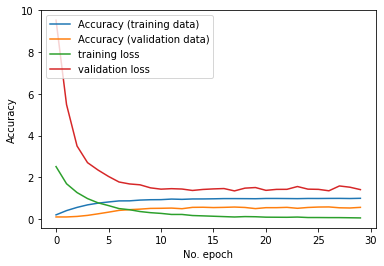

In [ ]:
plt.plot(history.history['accuracy'], label='Accuracy (training data)')
plt.plot(history.history['val_accuracy'], label='Accuracy (validation data)')
plt.plot(history.history["loss"], label="training loss")
plt.plot(history.history["val_loss"], label="validation loss")

plt.ylabel('Accuracy')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

reference:https://mathpretty.com/10675.html

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

preds = np.argmax(model.predict(X_test), axis = 1)
y_orig = np.argmax(y_test, axis = 1)
cm = confusion_matrix(preds, y_orig)
plt.figure(figsize=(10,10))
print(cm)
print(classes)

[[ 7  0  4  0  0  1  1  1  0  2]
 [ 1  8  0  0  1  0  0  1  0  1]
 [ 4  1  9  0  0  0  0  1  3  0]
 [ 0  1  0 18  3  3  0  0  2  3]
 [ 1  2  0  2 13  2  0  0  0  5]
 [ 1  0  0  0  1  7  0  0  1  0]
 [ 2  0  1  0  0  1 19  1  0  0]
 [ 0  2  3  0  0  0  0 13  4  0]
 [ 2  6  3  0  1  1  0  2  9  0]
 [ 2  0  0  0  1  5  0  1  1  9]]
['rock', 'pop', 'disco', 'classical', 'jazz', 'blues', 'metal', 'hiphop', 'reggae', 'country']


<Figure size 720x720 with 0 Axes>

In [ ]:
import itertools
# 绘制混淆矩阵
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Input
    - cm : 计算出的混淆矩阵的值
    - classes : 混淆矩阵中每一行每一列对应的列
    - normalize : True:显示百分比, False:显示个数
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    #print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


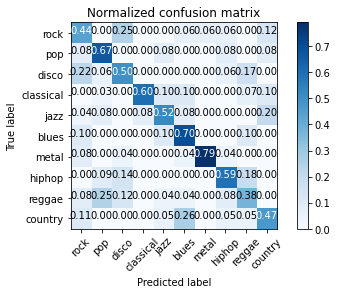

In [ ]:
plot_confusion_matrix(cm, classes=classes, normalize=True, title='Normalized confusion matrix')

# Transfer learning

In [ ]:
path='/content/drive/MyDrive/Dataset/Music-genre-classification/mel-spec-img/All_30s'

data_gen=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255., validation_split=0.2)

In [ ]:
(img_height, img_width)=(299,299)
batch_size=32
train_generator = data_gen.flow_from_directory(
    path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = data_gen.flow_from_directory(
    path, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data

Found 799 images belonging to 10 classes.
Found 199 images belonging to 10 classes.


In [ ]:
base_model=Xception(include_top=False,input_shape=(299,299,3))

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = tf.keras.Input(shape=(299,299,3))

x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)  
x = tf.keras.layers.Dense(512,activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x) 
x = tf.keras.layers.Dense(64,activation='relu')(x)
outputs = tf.keras.layers.Dense(10,activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)
model.summary()

83697664/83683744 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0      

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['acc'])
history = model.fit(train_generator, validation_data=validation_generator,epochs=20)

Epoch 1/20
25/25 [==============================] - 383s 15s/step - loss: 2.3005 - acc: 0.1352 - val_loss: 2.2322 - val_acc: 0.2060
Epoch 2/20
25/25 [==============================] - 7s 280ms/step - loss: 2.2098 - acc: 0.2403 - val_loss: 2.1469 - val_acc: 0.3216
Epoch 3/20
25/25 [==============================] - 7s 282ms/step - loss: 2.1339 - acc: 0.2829 - val_loss: 2.0723 - val_acc: 0.3970
Epoch 4/20
25/25 [==============================] - 7s 282ms/step - loss: 2.0358 - acc: 0.3417 - val_loss: 1.9820 - val_acc: 0.3819
Epoch 5/20
25/25 [==============================] - 7s 284ms/step - loss: 1.9417 - acc: 0.4030 - val_loss: 1.9015 - val_acc: 0.4121
Epoch 6/20
25/25 [==============================] - 7s 286ms/step - loss: 1.8588 - acc: 0.4205 - val_loss: 1.8371 - val_acc: 0.4070
Epoch 7/20
25/25 [==============================] - 7s 286ms/step - loss: 1.7682 - acc: 0.4693 - val_loss: 1.7640 - val_acc: 0.4322
Epoch 8/20
25/25 [==============================] - 7s 287ms/step - loss: 1.

In [ ]:
model.summary()

In [ ]:
base_model.trainable = True
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                             

In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-5)
model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['acc'])
history2 = model.fit(train_generator, validation_data=validation_generator,epochs=20)

Epoch 1/20
25/25 [==============================] - 40s 1s/step - loss: 1.1709 - acc: 0.6045 - val_loss: 1.3555 - val_acc: 0.5176
Epoch 2/20
25/25 [==============================] - 30s 1s/step - loss: 0.9766 - acc: 0.6671 - val_loss: 1.3592 - val_acc: 0.5075
Epoch 3/20
25/25 [==============================] - 29s 1s/step - loss: 0.8501 - acc: 0.6921 - val_loss: 1.2916 - val_acc: 0.5528
Epoch 4/20
25/25 [==============================] - 30s 1s/step - loss: 0.7774 - acc: 0.7259 - val_loss: 1.3368 - val_acc: 0.5477
Epoch 5/20
25/25 [==============================] - 30s 1s/step - loss: 0.6417 - acc: 0.7722 - val_loss: 1.2698 - val_acc: 0.5879
Epoch 6/20
25/25 [==============================] - 31s 1s/step - loss: 0.5436 - acc: 0.8310 - val_loss: 1.2457 - val_acc: 0.6080
Epoch 7/20
25/25 [==============================] - 31s 1s/step - loss: 0.4874 - acc: 0.8310 - val_loss: 1.2890 - val_acc: 0.6181
Epoch 8/20
25/25 [==============================] - 31s 1s/step - loss: 0.4173 - acc: 0.85

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                             

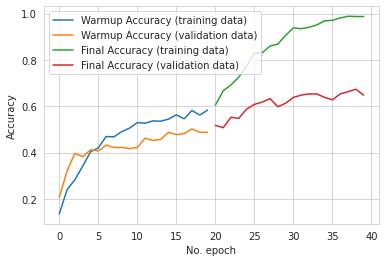

In [ ]:
plt.plot(range(0,20), history.history['acc'], label='Warmup Accuracy (training data)')
plt.plot(range(0,20), history.history['val_acc'], label='Warmup Accuracy (validation data)')

plt.plot(range(20,40), history2.history['acc'], label='Final Accuracy (training data)')
plt.plot(range(20,40), history2.history['val_acc'], label='Final Accuracy (validation data)')

plt.ylabel('Accuracy')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

